<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="max-width: 250px; display: inline"  alt="Wikistat"/></a>

<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" style="float:right; max-width: 250px; display: inline" alt="IMT"/> </a>
</center>

# Segmentation d'une clientèle bancaire

Les objectifs et données de ce tutoriel sont précisément décrits dans la [vignette](http://www.math.univ-toulouse.fr/~besse/Wikistat/pdf/st-scenar-explo-visa.pdf) disponible sur le site [wikistat.fr](http://wikistat.fr/). Ce calepin liste les commandes Pyhton produisant les mêmes résultats que le code SAS du scénario initial. 

## Lecture et prétraitement  des données

In [1]:
%matplotlib inline
import pylab as P
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
#Lecture
listeVar=['MATRIC','DEPTS','PVS','SEXEQ','AGER','FAMIQ', 
 'RELAT','PCSPQ','QUALS','G03G04S','G25G26S', 
 'G29G30S','G35G36S','G37G38S','G45G46S','G47G48S',
 'IMPNBS','REJETS','OPGNB','MOYRV','TAVEP','ENDET','GAGET',
 'GAGEC','GAGEM','KVUNB','QSMOY','QCRED','DMVTP','BOPPN',
 'FACAN','LGAGT','VIENB','VIEMT','UEMNB','UEMMTS','XLGNB',
 'XLGMT','YLVNB','YLVMT','NBELTS','MTELTS','NBCATS','MTCATS',
 'NBBECS','MTBECS','ZOCNB','NTCAS','NPTAG','SEGV2S','ITAVC',
 'HAVEF','JNBJD1S','JNBJD2S','JNBJD3S','CARVP']
path=""
# path="http://www.math.univ-toulouse.fr/~besse/Wikistat/data/"
visaraw = pd.read_table(path+'visa_raw_sas.dat',
                        sep=';',header=None, index_col=0, names=listeVar)

In [3]:
# Fonction pour définir le bon type "categorical" des variables qualitatives 
# avec dictionnaire des modalités pour le recodage
def create_categorical_data(df,column_name, cat_name_dic):
    cat_columns = pd.Categorical(df[column_name],ordered=False)
    new_categorie = [cat_name_dic[old_name] for old_name in cat_columns.categories]
    return cat_columns.rename_categories(new_categorie)

In [4]:
#FAMIQ
cat_name_dic = {'C':'Fcel','D':'Fdiv','M':'Fmar','S':'Fsep','U':'Fuli','V':'Fveu','inc':'Finc'}
visaraw["FAMIQ"]=create_categorical_data(visaraw,"FAMIQ", cat_name_dic)
#SEXEQ
cat_name_dic = {'1':'Shom','2':'Sfem','inc':'Sinc'}
visaraw["SEXEQ"]=create_categorical_data(visaraw,"SEXEQ", cat_name_dic)
#CARVP
cat_name_dic = {'non':'Cnon','oui':'Coui'}
visaraw["CARVP"]=create_categorical_data(visaraw,"CARVP", cat_name_dic)
#PCSPQ
visaraw["PCSPQ"] = visaraw["PCSPQ"].str.get(0).replace("0","i")
cat_name_dic = {'1':'Pagr', '2':'Part', '3':'Pcad', '4':'Pint', '5':'Pemp','6':'Pouv',
                '7':'Pret', '8':'Psan', 'i':'Pinc'}
visaraw["PCSPQ"]=create_categorical_data(visaraw,"PCSPQ", cat_name_dic)

In [5]:
# Suppression d'observations non pertinentes 
# interdits bancaires, comptes professionnels
visaraw = visaraw[visaraw.NBCATS!= 1]
visaraw = visaraw[visaraw.NBBECS!= 1]

visaraw= visaraw[np.logical_not(visaraw.G29G30S.isin(['B','X']))] 
visaraw= visaraw[np.logical_not(visaraw.G03G04S.isin(['B','X']))] 
visaraw= visaraw[np.logical_not(visaraw.G45G46S.isin(['A','B','X']))] 
visaraw= visaraw[np.logical_not(visaraw.G37G38S.isin(['A']))] 
visaraw= visaraw[np.logical_not(visaraw.G25G26S.isin(['A','B','X']))] 
visaraw= visaraw[np.logical_not(visaraw.G47G48S.isin(['B']))] 

In [6]:
# Suppression de données manquantes
visaraw = visaraw[visaraw.AGER!='.']
# Seulement les clients de 18 à 65 ans
visaraw["AGER"]=visaraw["AGER"].astype(int)
visaraw=visaraw[np.logical_and(visaraw["AGER"]<66,visaraw["AGER"]>17)]

visaraw["ZOCNB"]=visaraw["ZOCNB"].replace(".",np.nan)
visaraw["DMVTP"]=visaraw["DMVTP"].replace(".",np.nan)

In [7]:
# Modificaton des types des variables 
listeVarFl=['RELAT','IMPNBS','REJETS','OPGNB','MOYRV',
'TAVEP','ENDET','GAGET','GAGEC','GAGEM','KVUNB','QSMOY','QCRED',
'DMVTP','BOPPN','FACAN','LGAGT','VIENB','VIEMT','UEMNB','UEMMTS','XLGNB',
 'XLGMT','YLVNB','YLVMT','NBELTS','MTELTS','NBCATS','MTCATS',
 'NBBECS','MTBECS','ZOCNB','NTCAS','NPTAG','ITAVC',
 'HAVEF','JNBJD1S','JNBJD2S','JNBJD3S']
visaraw[listeVarFl]=visaraw[listeVarFl].astype(float)

In [8]:
# Un seule variable nombre de jours de débit
visaraw["JNBJD"]=visaraw["JNBJD1S"]+visaraw["JNBJD2S"]+visaraw["JNBJD3S"] 

In [9]:
# suppression des variables devenues inutiles
listeVarSup=["DEPTS","QUALS","G03G04S","G25G26S","G29G30S","G35G36S",
            "G37G38S","G45G46S","G47G48S","SEGV2S","PVS","JNBJD1S","JNBJD2S","JNBJD3S"]
visaraw.drop(listeVarSup,inplace=True,axis=1)

In [10]:
# mise à jour de la liste
listeVar = [x for x in listeVar if x not in listeVarSup]

## Desciption univariée et bivariée

In [11]:
visaprem=visaraw
visaprem.mean()

AGER          42.532153
RELAT        157.117428
IMPNBS         0.000000
REJETS        -0.072693
OPGNB          1.505126
MOYRV         47.626281
TAVEP      57249.062442
ENDET          5.456664
GAGET      77316.455732
GAGEC       4198.657036
GAGEM      20230.041938
KVUNB          1.027959
QSMOY      10674.265610
QCRED         25.906803
DMVTP         19.059044
BOPPN         28.999068
FACAN      23379.273066
LGAGT      52887.756757
VIENB          0.239515
VIEMT      35914.712954
UEMNB          1.473439
UEMMTS     75442.118360
XLGNB          0.652377
XLGMT      32183.942218
YLVNB          0.758621
YLVMT      20739.696179
NBELTS         0.058714
MTELTS      4325.424045
NBCATS         0.002796
MTCATS        19.710158
NBBECS         0.000932
MTBECS     18173.345760
ZOCNB         11.500629
NTCAS          1.069897
NPTAG          0.136067
ITAVC     146819.268406
HAVEF      50727.357875
JNBJD         12.084809
dtype: float64

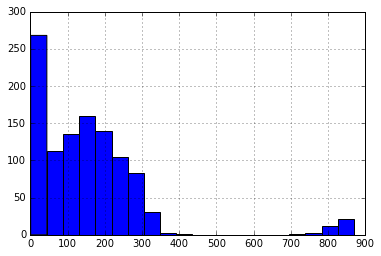

In [12]:
visaprem["RELAT"].hist(bins=20)
P.show()

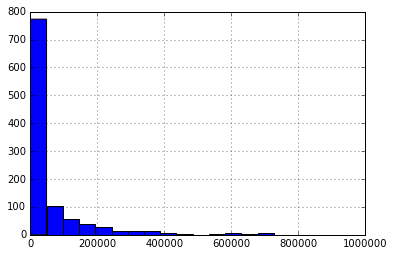

In [13]:
visaprem["TAVEP"].hist(bins=20)
P.show()

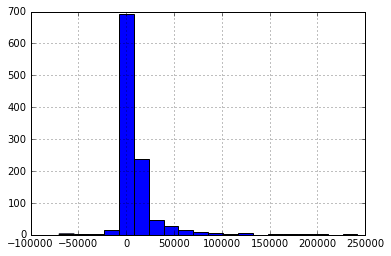

In [14]:
visaprem["QSMOY"].hist(bins=20)
P.show()

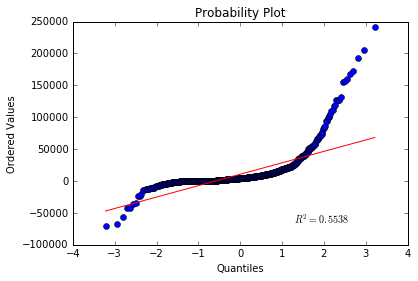

In [15]:
import scipy.stats as stats
stats.probplot(visaprem["QSMOY"], dist="norm", plot=P)
P.show()

In [16]:
visaprem["PCSPQ"].value_counts()

Pemp    288
Pcad    276
Psan    199
Pint    170
Pouv     85
Part     31
Pret     21
Pinc      2
Pagr      1
dtype: int64

In [17]:
visaprem["FAMIQ"].value_counts()

Fmar    547
Fcel    360
Fdiv     86
Finc     32
Fuli     25
Fsep     14
Fveu      9
dtype: int64

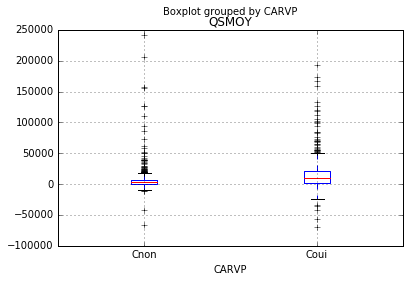

In [18]:
visaprem.boxplot('QSMOY','CARVP')
P.show()

CARVP  Cnon  Coui
SEXEQ            
Shom    365   303
Sfem    349    56


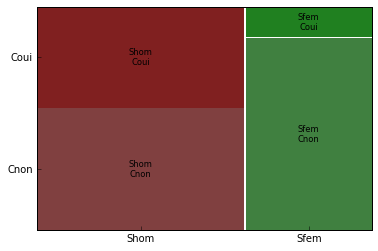

In [19]:
from statsmodels.graphics.mosaicplot import mosaic
visaprem["SEXEQ"]=visaprem["SEXEQ"].cat.remove_unused_categories()
table=pd.crosstab(visaprem["SEXEQ"],visaprem["CARVP"])
print(table)
mosaic(table.stack())
P.show()

CARVP  Cnon  Coui
NTCAS            
0       261    17
1       376   143
2        66   146
3        10    42
4         1    10
5         0     1


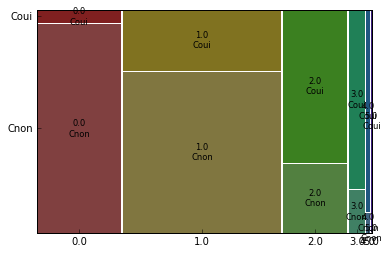

In [20]:
table=pd.crosstab(visaprem["NTCAS"],visaprem["CARVP"])
print(table)
mosaic(table.stack())
P.show()

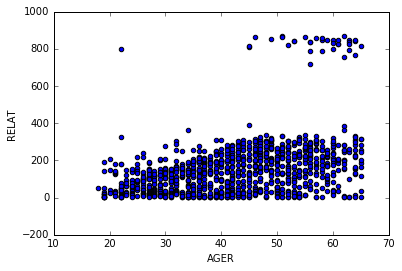

In [21]:
visaprem.plot('AGER','RELAT',kind='scatter')
P.show()

In [22]:
table=pd.crosstab(visaprem["NTCAS"],visaprem["ZOCNB"].isnull())
print(table)

ZOCNB  False  True 
NTCAS              
0          0    278
1        519      0
2        212      0
3         52      0
4         11      0
5          1      0


In [23]:
#Transformations des variables 
## regroupements de modalités
visatrans=visaprem
FAMIQ_DIC = {"Fmar":'Fcou',"Fuli":'Fcou',"Fdiv":'Fseu','Fveu':'Fseu',
                        "Fsep":'Fseu',"Fcel":'Fseu'}
PCSPQ_DIC = {"Pagr":"Pint",'Part':"Pint","Pret":"Psan","Pinc":"Psan"}

visatrans["PCSPQ"]=visatrans["PCSPQ"].astype(str).replace(PCSPQ_DIC)
visatrans["FAMIQ"]=visatrans["FAMIQ"].astype(str).replace(FAMIQ_DIC)

In [24]:
# complétion de valeurs
visatrans["ZOCNB"].fillna(0, inplace=True)
visatrans["ZOCNB"]
visatrans = visatrans[visatrans.DMVTP.notnull()]
# Correction ancienneté relation
visatrans["RELAT"]= [x-720 if x>600 else x for x in visatrans["RELAT"]]

In [25]:
# log des variables de distribution dissymétrique 
def log1(x):
    return np.log(1+x)
listeVarLog=['OPGNB','MOYRV','TAVEP','ENDET','GAGET','GAGEC',
'GAGEM','QCRED','DMVTP','BOPPN','FACAN','LGAGT',
'VIEMT','XLGMT','YLVMT','ITAVC','HAVEF','JNBJD']
visatrans[listeVarLog]=log1(visatrans[listeVarLog])
visatrans["ZOCNB"]=np.sqrt(visatrans["ZOCNB"])

In [26]:
visatrans2 = visatrans[["SEXEQ","AGER","FAMIQ","RELAT","PCSPQ","OPGNB", "MOYRV","TAVEP", "ENDET", "GAGET","GAGEC", "GAGEM", "KVUNB","QSMOY", "QCRED", "DMVTP","BOPPN", "FACAN", "LGAGT","VIENB", "VIEMT", "UEMNB","XLGNB", "XLGMT", "YLVNB","YLVMT", "ZOCNB", "NPTAG","ITAVC", "HAVEF","JNBJD", "CARVP"]]
visatrans2.head()

,SEXEQ,AGER,FAMIQ,RELAT,PCSPQ,OPGNB,MOYRV,TAVEP,ENDET,GAGET,...,XLGNB,XLGMT,YLVNB,YLVMT,ZOCNB,NPTAG,ITAVC,HAVEF,JNBJD,CARVP
MATRIC,,,,,,,,,,,,,,,,,,,,,
148009,Shom,51,Fcou,238,Pcad,0.000000,4.753590,13.461603,1.609438,11.688701,...,2,13.161865,2,12.110635,3.741657,0,14.080718,13.230263,0.693147,Coui
442153,Shom,52,Fcou,270,Pint,1.609438,9.882264,9.096163,0.000000,0.000000,...,2,9.096163,0,0.000000,2.236068,0,16.804029,11.804826,0.000000,Coui
552427,Shom,58,Fcou,139,Pcad,0.000000,3.713572,8.132413,0.000000,0.000000,...,0,0.000000,1,8.132413,0.000000,0,11.717872,0.000000,0.000000,Coui
556005,Shom,27,Fseu,99,Psan,0.000000,2.890372,11.242717,0.000000,0.000000,...,1,10.743178,2,10.309286,3.741657,0,11.329303,0.000000,0.000000,Coui
556686,Shom,49,Fseu,89,Pemp,0.000000,5.926926,13.067592,0.000000,12.250391,...,3,12.899220,2,11.203025,3.316625,1,13.111856,9.972267,2.772589,Coui


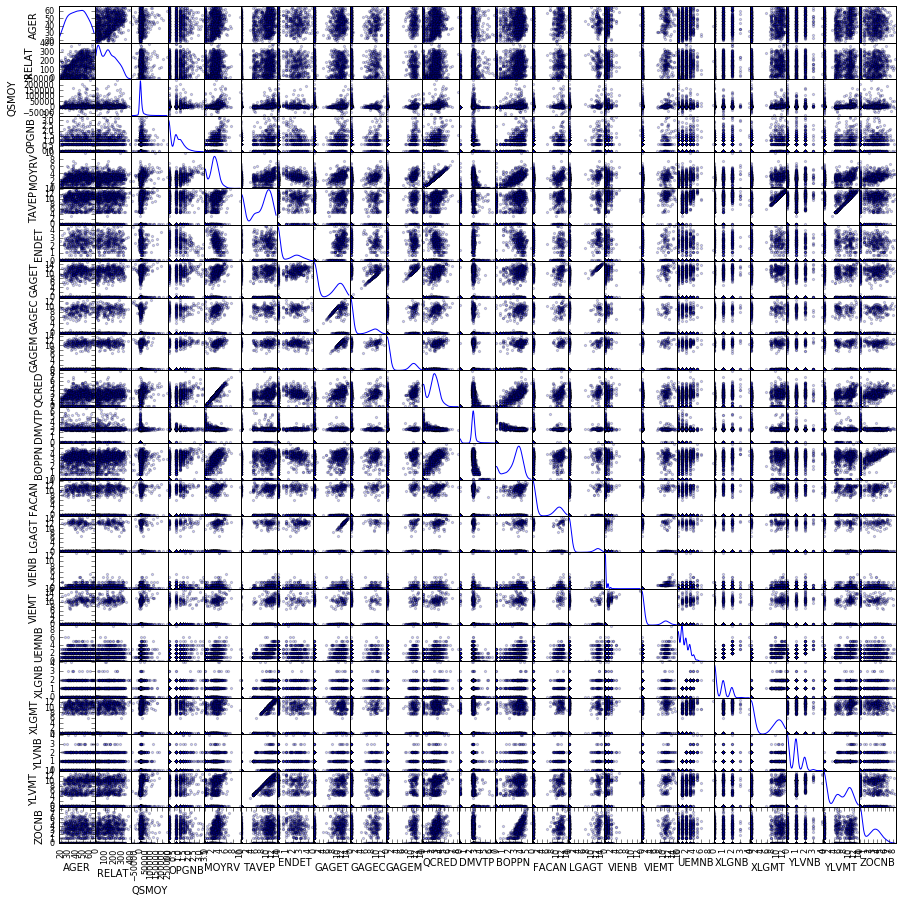

In [27]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(visatrans[["AGER", "RELAT","QSMOY", "OPGNB", "MOYRV","TAVEP", "ENDET", "GAGET","GAGEC","GAGEM", "QCRED", "DMVTP","BOPPN","FACAN","LGAGT","VIENB","VIEMT","UEMNB","XLGNB","XLGMT","YLVNB","YLVMT","ZOCNB"]], alpha=0.2, figsize=(15, 15), diagonal='kde')
P.show()

## Analyse en composantes principales

In [28]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# définition de la commande
pca = PCA()
# Sélection des variables quantitatives
dat=visatrans[["AGER","RELAT","KVUNB", "OPGNB", "MOYRV","TAVEP","ENDET","GAGET","GAGEC","GAGEM","QCRED","DMVTP","BOPPN","FACAN","LGAGT","VIEMT","XLGMT","YLVMT","ITAVC","HAVEF","JNBJD","ZOCNB"]]
# centrage et réduction
data = (dat - dat.mean()) / dat.std()
# composantes principales
C = pca.fit(data).transform(data)

### Choix de dimension

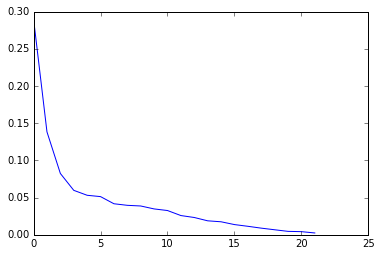

In [29]:
# Eboulis des valeurs propres
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.show()

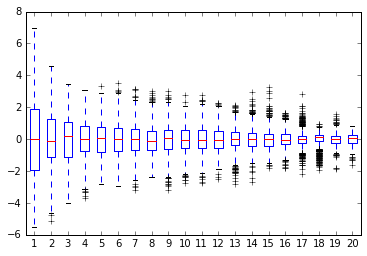

In [30]:
# Diagrammes boîte des composantes principales
plt.figure()
plt.boxplot(C[:,0:20])
plt.show()

### Représentation des individus

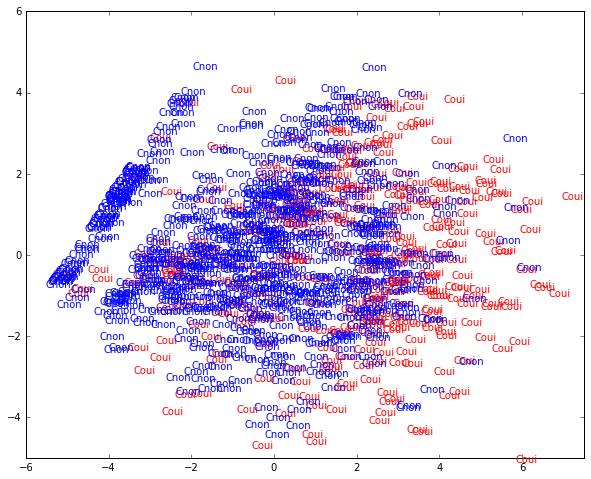

In [31]:
plt.figure(figsize=(10,8))
for i, j, nom in zip(C[:,0], C[:,1], visatrans['CARVP']):
    color = "red" if nom == "Coui" else "blue"
    plt.text(i, j, nom, color=color)
plt.axis((-6,7.5,-5,6))  
P.show()

### Variables et cercle des corrélations

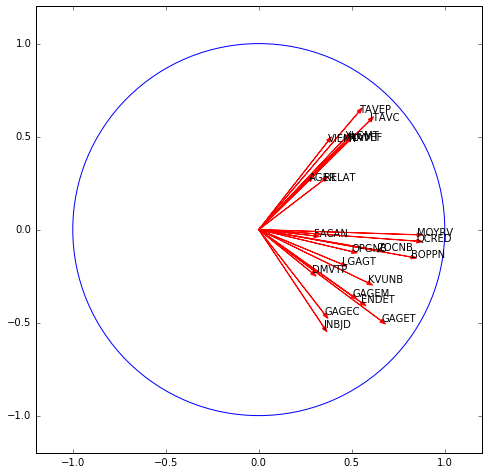

In [32]:
# coordonnées des variables
coord1=pca.components_[0]*np.sqrt(pca.explained_variance_[0])
coord2=pca.components_[1]*np.sqrt(pca.explained_variance_[1])
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
for i, j, nom in zip(coord1,coord2, data.columns):
    plt.text(i, j, nom)
    plt.arrow(0,0,i,j,color='r')
plt.axis((-1.2,1.2,-1.2,1.2))
# cercle
c=plt.Circle((0,0), radius=1, color='b', fill=False)
ax.add_patch(c)
P.show()

### Classification des variables

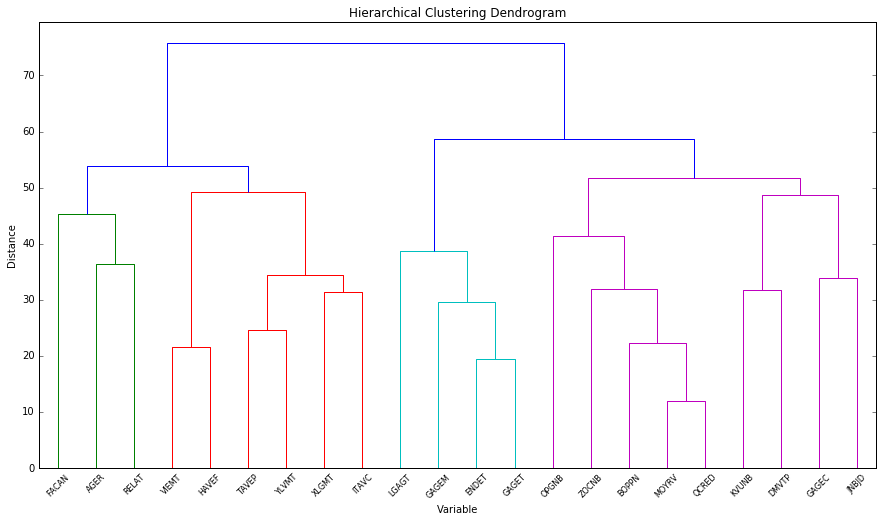

In [33]:
# Utilisée pour aider à l'interprétation du plan principal 
# lorsque le nombre de variables est important
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(data.T, 'ward')
plt.figure(figsize=(15, 8))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Variable')
plt.ylabel('Distance')
dendrogram(Z,leaf_font_size=8.,labels=data.columns)
plt.show()

## Analyse multiple des correspondances 

In [73]:
#Recodage des variables 
import random
visapremv=visatrans2

In [74]:
# regroupement de classes et recodages
def rep_fami(x):
    if random.random()<0.45:
        x="Fseu"
    else:
        x="Fcou"
    return x
visapremv["FAMIQ"]=[x if x!="Finc" else rep_fami(x) for x in visapremv["FAMIQ"]]

In [75]:
kvunbq = ["K0" if x in [0,1] else "K1" for x in visapremv["KVUNB"] ]
visapremv["KVUNBQ"]=pd.Categorical(kvunbq,ordered=False)

vienbq = ["V0" if x==0 else "V1" for x in visapremv["VIENB"]]
visapremv["VIENBQ"]=pd.Categorical(vienbq,ordered=False)

uemnbq = ["U0" if x==0 else "U1" if x==1 else "U2" for x in visapremv["UEMNB"] ]
visapremv["UEMNBQ"]=pd.Categorical(uemnbq,ordered=False)

xlgnbq = ["X0" if x==0 else "X1" if x==1 else "X2" for x in visapremv["XLGNB"] ]
visapremv["XLGNBQ"]=pd.Categorical(xlgnbq,ordered=False)

ylvnbq = ["Y0" if x==0 else "Y1" if x==1 else "Y2" for x in visapremv["YLVNB"] ]
visapremv["YLVNBQ"]=pd.Categorical(ylvnbq,ordered=False)

zocnbq = ["Z0" if x ==0 else "Z1" for x in visapremv["ZOCNB"] ]
visapremv["ZOCNBQ"]=pd.Categorical(zocnbq,ordered=False)

nptagq = ["N0" if x ==0 else "N1" for x in visapremv["NPTAG"] ]
visapremv["NPTAGQ"]=pd.Categorical(nptagq,ordered=False)

In [76]:
def rec(df,col_name,a,b):
    colq = [b if x>0 else a for x in df[col_name]]
    return colq

visapremv["ENDETQ"]=pd.Categorical(rec(visapremv,"ENDET","E0","E1"),ordered=False)
visapremv["GAGETQ"]=pd.Categorical(rec(visapremv,"GAGET","G0","G1"),ordered=False)
visapremv["FACANQ"]=pd.Categorical(rec(visapremv,"FACAN","F0","F1"),ordered=False)
visapremv["LGAGTQ"]=pd.Categorical(rec(visapremv,"LGAGT","L0","L1"),ordered=False)
visapremv["HAVEFQ"]=pd.Categorical(rec(visapremv,"HAVEF","H0","H1"),ordered=False)

In [77]:
visapremw=visapremv[["AGER","RELAT","QSMOY","OPGNB","MOYRV","TAVEP","DMVTP","BOPPN","ITAVC","JNBJD"]]

In [78]:
visapremw["AGEQ"]=pd.qcut(visapremw.AGER,3,labels=["A0","A1","A2"])
visapremw["RELATQ"]=pd.qcut(visapremw.RELAT,3,labels=["R0","R1","R2"])
visapremw["QSMOYQ"]=pd.qcut(visapremw.QSMOY,3,labels=["Q0","Q1","Q2"])
visapremw["MOYRVQ"]=pd.qcut(visapremw.MOYRV,3,labels=["M0","M1","M2"])
visapremw["TAVEPQ"]=pd.qcut(visapremw.TAVEP,3,labels=["T0","T1","T2"])
visapremw["DMVTPQ"]=pd.qcut(visapremw.DMVTP,3,labels=["D0","D1","D2"])
visapremw["BOPPNQ"]=pd.qcut(visapremw.BOPPN,3,labels=["B0","B1","B2"])
visapremw["ITAVCQ"]=pd.qcut(visapremw.ITAVC,3,labels=["I0","I1","I2"])

# suppression des variables devenues inutiles
listeVarSup=["AGER","RELAT","QSMOY","MOYRV","TAVEP","DMVTP","BOPPN","ITAVC"]
visapremw.drop(listeVarSup,inplace=True,axis=1)

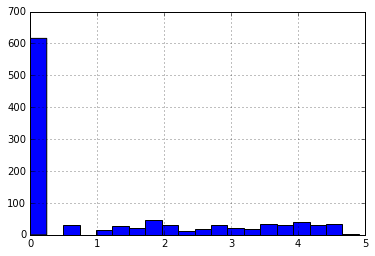

In [80]:
visapremw["JNBJD"].hist(bins=20)
P.show()

In [81]:
# Problème pour deux variables avec beaucoup de 0
#Source : http://stackoverflow.com/questions/20158597/how-to-qcut-with-non-unique-bin-edges
import pandas.core.algorithms as algos
mx = np.ma.masked_equal(visapremw.JNBJD.as_matrix(), 0, copy=True)
bina = algos.quantile(visapremw.JNBJD.as_matrix()[~mx.mask], np.linspace(0, 1, 3))
bina = np.insert(bina, 0, 0)
bina[1] = bina[1]-(bina[1]/2)
result = pd.tools.tile._bins_to_cuts(visapremw.JNBJD.as_matrix(), bina, include_lowest=True)
visapremw["JNBJDQ"]=pd.cut(visapremw.JNBJD,bins=bina,labels=["J0","J1","J2"])
visapremw["JNBJDQ"]=visapremw["JNBJDQ"].fillna('J0')

mx = np.ma.masked_equal(visapremw.OPGNB.as_matrix(), 0, copy=True)
bina = algos.quantile(visapremw.OPGNB.as_matrix()[~mx.mask], np.linspace(0, 1, 3))
bina = np.insert(bina, 0, 0)
bina[1] = bina[1]-(bina[1]/2)
result = pd.tools.tile._bins_to_cuts(visapremw.JNBJD.as_matrix(), bina, include_lowest=True)
visapremw["OPGNBQ"]=pd.cut(visapremw.OPGNB,bins=bina,labels=["O0","O1","O2"])
visapremw["OPGNBQ"]=visapremw["OPGNBQ"].fillna('O0')

del visapremw["OPGNB"]
del visapremw["JNBJD"]

In [85]:
visapremw["JNBJDQ"].value_counts()

J0    616
J1    233
J2    218
dtype: int64

In [86]:
fram=[visapremv,visapremw]
visapremvw=pd.concat(fram,1)

In [87]:
visapremvw.head()

,SEXEQ,AGER,FAMIQ,RELAT,PCSPQ,OPGNB,MOYRV,TAVEP,ENDET,GAGET,...,AGEQ,RELATQ,QSMOYQ,MOYRVQ,TAVEPQ,DMVTPQ,BOPPNQ,ITAVCQ,JNBJDQ,OPGNBQ
MATRIC,,,,,,,,,,,,,,,,,,,,,
148009,Shom,51,Fcou,238,Pcad,0.000000,4.753590,13.461603,1.609438,11.688701,...,A2,R2,Q2,M2,T2,D0,B2,I2,J1,O0
442153,Shom,52,Fcou,270,Pint,1.609438,9.882264,9.096163,0.000000,0.000000,...,A2,R2,Q2,M2,T1,D0,B2,I2,J0,O2
552427,Shom,58,Fcou,139,Pcad,0.000000,3.713572,8.132413,0.000000,0.000000,...,A2,R1,Q0,M2,T1,D1,B0,I2,J0,O0
556005,Shom,27,Fseu,99,Psan,0.000000,2.890372,11.242717,0.000000,0.000000,...,A0,R1,Q2,M1,T2,D0,B1,I2,J0,O0
556686,Shom,49,Fseu,89,Pemp,0.000000,5.926926,13.067592,0.000000,12.250391,...,A1,R1,Q2,M2,T2,D0,B2,I2,J1,O0


In [88]:
#AFCM des variables socio économiques
import mca
# tableau disjonctif complet des variables qualitatives
D=mca.dummy(visapremvw.select_dtypes(include=[pd.Categorical,"object"]))
mct=mca.mca(D,cols=["FAMIQ","SEXEQ","PCSPQ","AGEQ","RELATQ"],benzecri=False)
DD=D.drop(["FAMIQ","SEXEQ","PCSPQ","AGEQ","RELATQ"],axis=1)

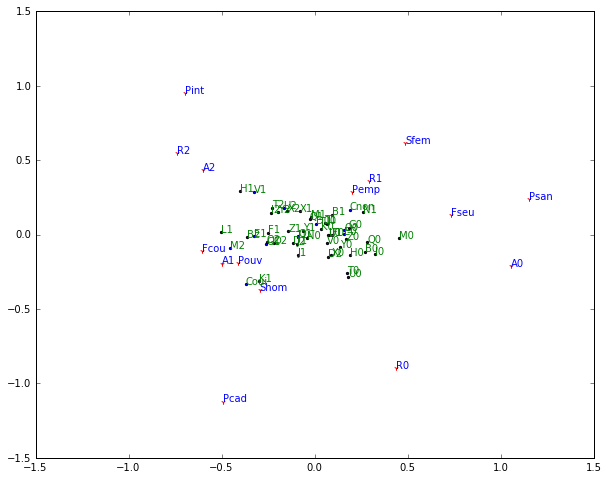

In [89]:
fig = plt.figure(1, figsize=(10, 8))
l=np.shape(mca.dummy(DD).columns.levels[0])[0]

for i, j, nom in zip(mct.fs_c()[:, 0],-mct.fs_c()[:, 1], ["Fcou","Fseu","Shom","Sfem","Pcad","Pemp" ,"Pint","Pouv","Psan","A0","A1","A2","R0","R1","R2"]):
    plt.text(i, j, nom,color='b')
plt.scatter(mct.fs_c()[:, 0],-mct.fs_c()[:, 1],marker='1',c='r')
idx=0
for i in mca.dummy(DD).columns.levels[0]:
    a=mct.fs_c_sup(DD[i],ncols=2)
    for k,l,nom in zip(-a[:,0],a[:,1],mca.dummy(DD).columns.levels[1][idx:idx+np.shape(a)[0]]):
        plt.text(k,l, nom,color='g')
    idx=idx+np.shape(a)[0]    
    plt.scatter(-a[:,0],a[:,1],marker='.')
plt.axis((-1.5,1.5,-1.5,1.5))
P.show()

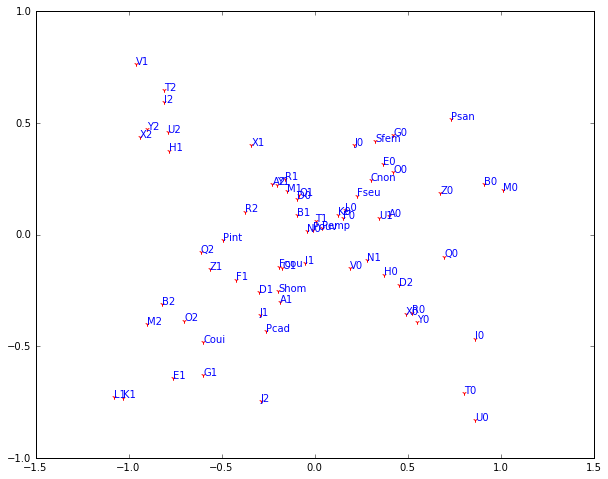

In [90]:
# AFCM de toutes les variables qualitatives
mca_comp=mca.mca(D,benzecri=False)
fig = plt.figure(1, figsize=(10, 8))
# graphe des modalités
for i, j, nom in zip(mca_comp.fs_c()[:, 0],-mca_comp.fs_c()[:, 1],D.columns.get_level_values(1)):
    plt.text(i, j, nom,color='b')
plt.scatter(mca_comp.fs_c()[:, 0],-mca_comp.fs_c()[:, 1],marker='1',c='r')
P.show()

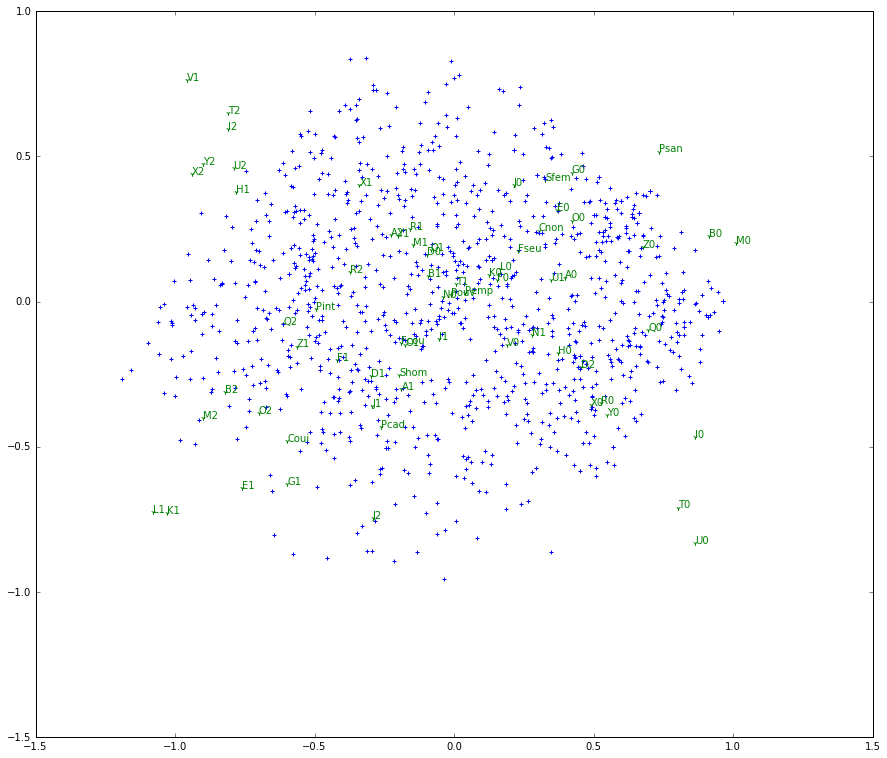

In [91]:
mca_comp=mca.mca(D,benzecri=False)
fig = plt.figure(1, figsize=(15, 13))
# graphe des individus et des modalités
for i, j, nom in zip(mca_comp.fs_c()[:, 0],-mca_comp.fs_c()[:, 1],D.columns.get_level_values(1)):
    #print(nom,i,j)
    plt.text(i, j, nom,color='g')
plt.scatter(mca_comp.fs_c()[:, 0],-mca_comp.fs_c()[:, 1],marker='1',c='g')
plt.scatter(mca_comp.fs_r()[:, 0],-mca_comp.fs_r()[:, 1],marker='+',c='b')
P.show()

## Clustering des individus avec variables quantitatives

In [92]:
# Sélection des variables quantitatives
visaprems=visapremvw.select_dtypes(include=["int32","float","int64"])
# Centrage et réduction
visaprems = (visaprems - visaprems.mean()) / visaprems.std()

In [93]:
# Classification d'un grand tableau par k-means puis CAH
# si la CAH n'est pas possible
## k-means avec 100 classes
from sklearn.cluster import *
T=k_means(visaprems,100)
poids=np.zeros((100,))
for i in T[1]:
    poids[i]=1./np.size(T[1])
np.sum(poids)

0.09372071227741334

In [94]:
## CAH des barycentres des classes
## Calcul de la matrices des distances pondérées
def weightedL2(a,b,wa,wb):
    q = wa*a-wb*b
    return np.sqrt((q*q).sum())
dist=np.zeros((100,100))
for i in range(dist.shape[0]):
    for j in range(dist.shape[1]):
        dist[i,j]=weightedL2(T[0][i],T[0][j],poids[i],poids[j])
from scipy.cluster.hierarchy import *
Q= linkage(dist, 'ward')        
        

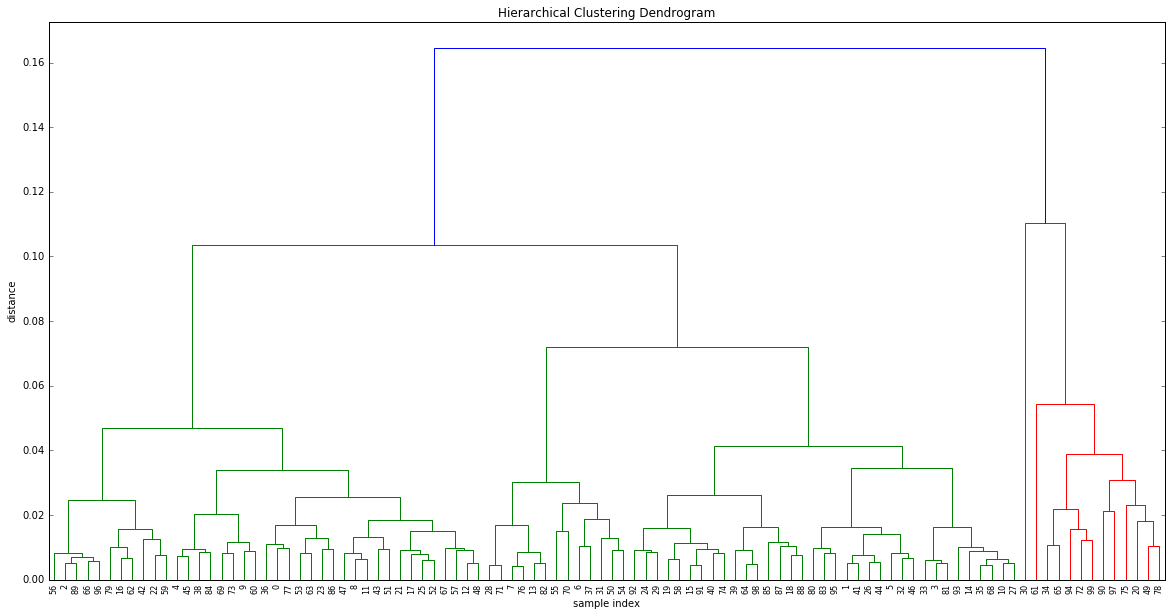

In [95]:
## Dendrogramme des barycentres des classes
plt.figure(figsize=(20, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(Q,leaf_font_size=8.)
plt.show()

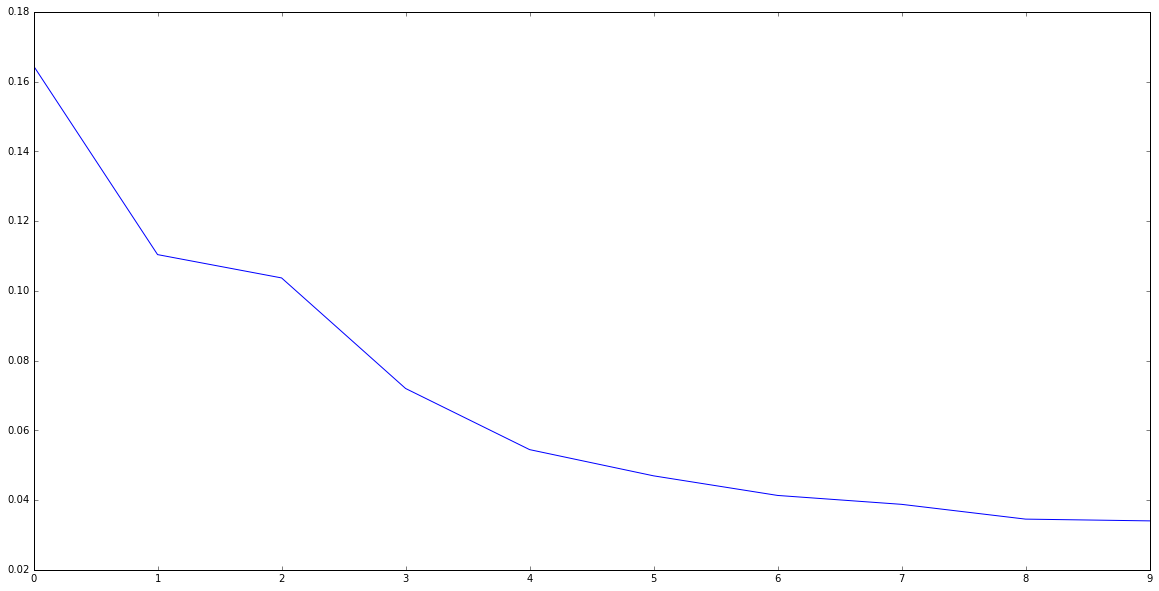

In [96]:
## Choix du nombre de classes
plt.figure(figsize=(20, 10))
plt.plot(maxdists(Q)[::-1][0:10])
plt.show()

In [97]:
## k-means avec le nombre choisi de classes 
Z=k_means(visaprems,5)
visaprems['Classe']=Z[1]
pca=PCA()
C = pca.fit(visaprems.drop('Classe',axis=1)).transform(visaprems.drop('Classe',axis=1))

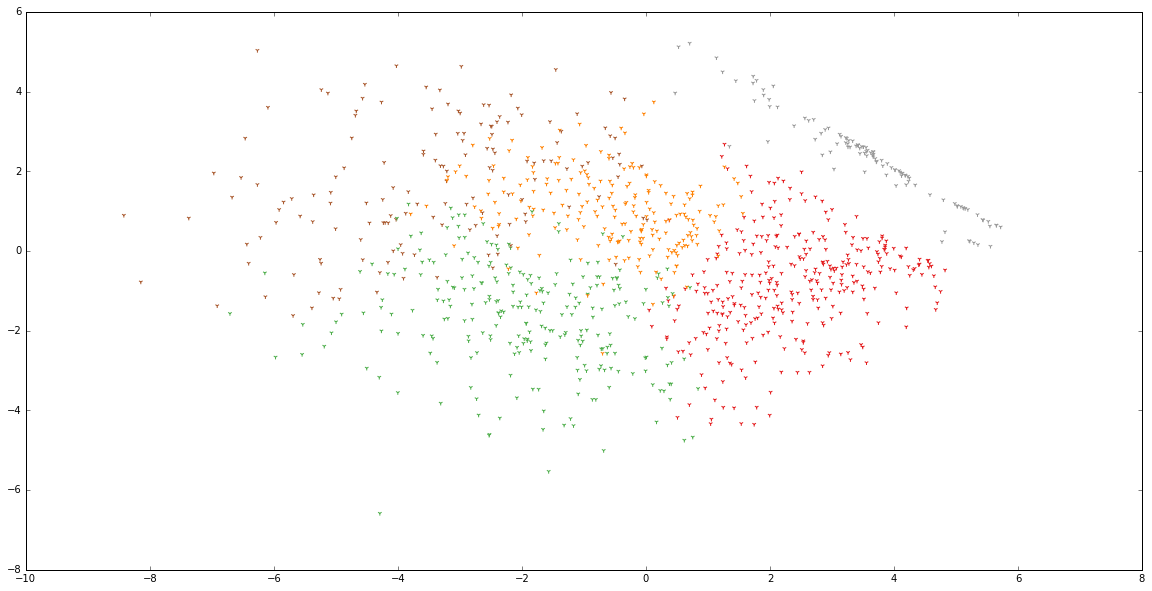

In [98]:
## représentation des classes dans l'ACP
plt.figure(figsize=(20, 10))
plt.scatter(C[:,0], C[:,1],marker='1',c=visaprems["Classe"],cmap=plt.cm.Set1)
plt.show()

## Clustering sur composantes de l'AFCM

In [99]:
import mca
# Calcul des coordonnées des individus dans l'AFCM
D=mca.dummy(visapremvw.select_dtypes(include=[pd.Categorical,"object"]))
mca_comp=mca.mca(D,benzecri=False)

In [100]:
mca_comp.fs_r().shape

(1067L, 29L)

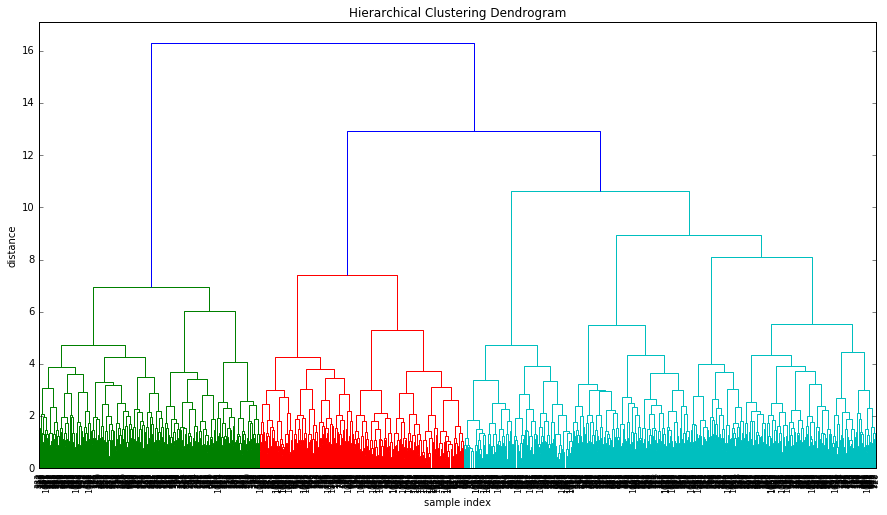

In [101]:
# Avec n grand, il faudrait suivre la même stratégie que pour 
# l'acp: k-means puis CAH sur barycentres puis re-k-means. 
# On fait directement la CAH 
# data = (dat - dat.mean()) / dat.std()
ZZ = linkage(mca_comp.fs_r(), 'ward')
plt.figure(figsize=(15, 8))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(ZZ,leaf_font_size=8.)
plt.show()

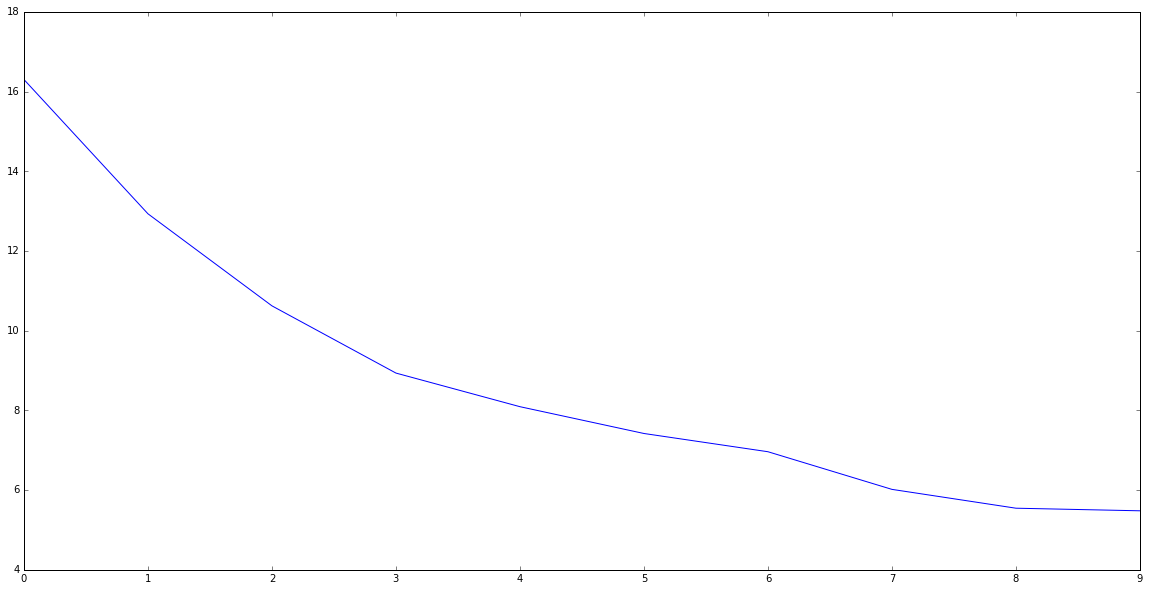

In [102]:
## Choix du nombre de classes
plt.figure(figsize=(20, 10))
plt.plot(maxdists(ZZ)[::-1][0:10])
plt.show()

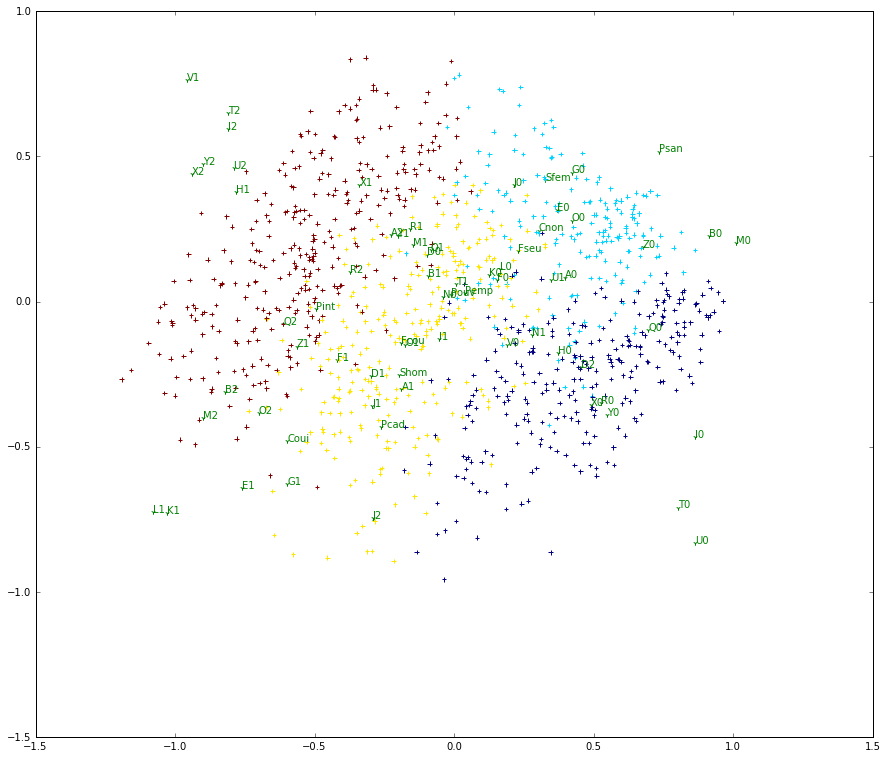

In [103]:
# k-means des composantes de l'AFCM avec 4 classes
KL=k_means(mca_comp.fs_r(),4)
visaprems["Klasse"]=KL[1]
fig = plt.figure(1, figsize=(15, 13))
# Représentation des classes dans les composantes de l'AFCM
for i, j, nom in zip(mca_comp.fs_c()[:, 0],-mca_comp.fs_c()[:, 1],D.columns.get_level_values(1)):
    plt.text(i, j, nom,color='g')
plt.scatter(mca_comp.fs_c()[:, 0],-mca_comp.fs_c()[:, 1],marker='1',c='g')
plt.scatter(mca_comp.fs_r()[:, 0],-mca_comp.fs_r()[:, 1],marker='+',c=visaprems["Klasse"])
plt.show()

In [104]:
# Ajout de la variable Classe dans la table
visapremvw["Klasse"]=KL[1]
visapremvw["Klasse"]=pd.Categorical(visapremvw["Klasse"],ordered=False)
visapremvw["Klasse"]=visapremvw["Klasse"].cat.rename_categories(['KL2','KL1','KL0','KL3'])
visapremvw["Klasse"].value_counts()

KL3    314
KL0    280
KL2    271
KL1    202
dtype: int64

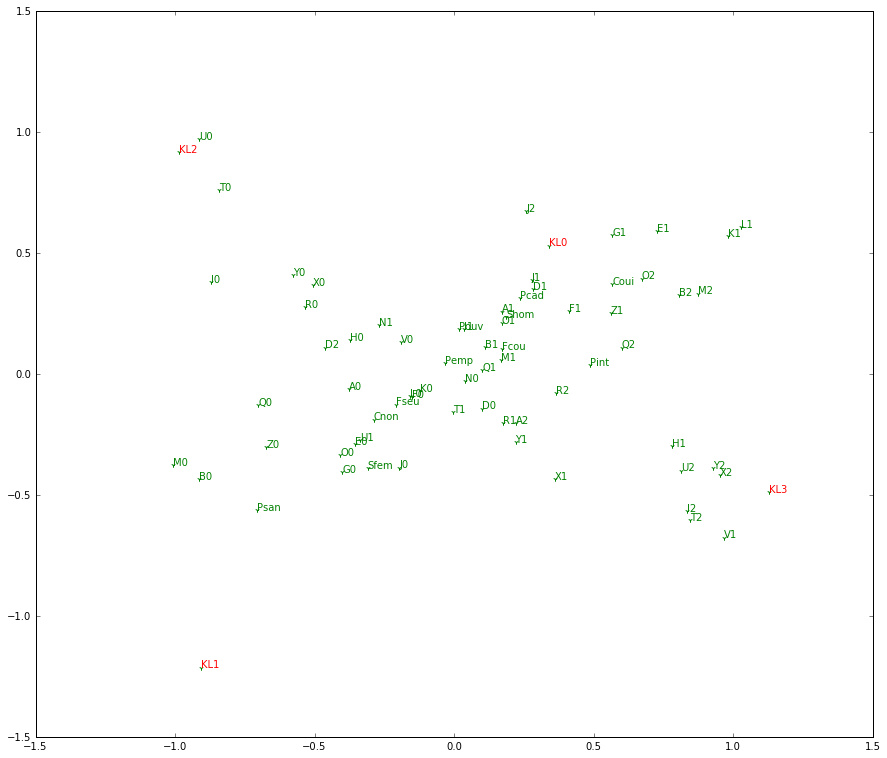

In [105]:
# AFCM avec la variable Classe
Data=mca.dummy(visapremvw.select_dtypes(include=[pd.Categorical,"object"]))
mca_class=mca.mca(Data,benzecri=False)
fig = plt.figure(1, figsize=(15, 13))
# Graphe des modalités
for i, j, nom in zip(mca_class.fs_c()[:, 0],-mca_class.fs_c()[:, 1],Data.columns.get_level_values(1)):
    if nom=='KL0' or nom=='KL1' or nom=='KL2' or nom=='KL3':
        plt.text(i, j, nom,color='r') 
    else:    
        plt.text(i, j, nom,color='g')
plt.scatter(mca_class.fs_c()[:, 0],-mca_class.fs_c()[:, 1],marker='1',c='g')
plt.show()

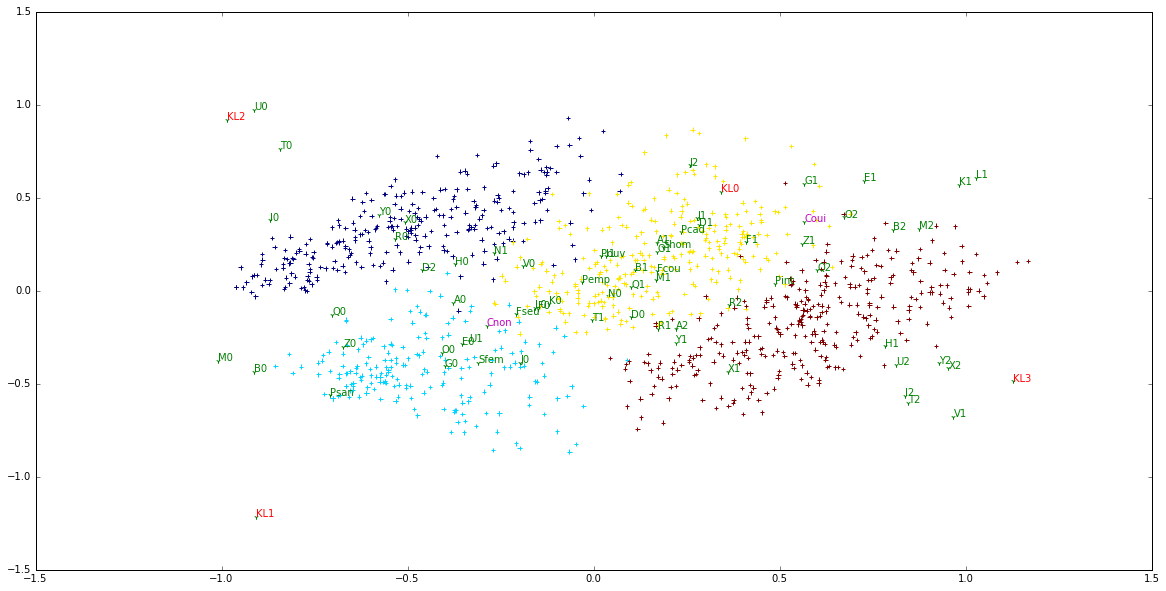

In [106]:
# représentation des classes ou segments de clientèles
fig = plt.figure(1, figsize=(20, 10))

for i, j, nom in zip(mca_class.fs_c()[:, 0],-mca_class.fs_c()[:, 1],Data.columns.get_level_values(1)):
    if nom=='KL0' or nom=='KL1' or nom=='KL2' or nom=='KL3':
        plt.text(i, j, nom,color='r')
    elif nom=='Coui' or nom=='Cnon':
        plt.text(i, j, nom,color='m')
    else:    
        plt.text(i, j, nom,color='g')
plt.scatter(mca_class.fs_c()[:, 0],-mca_class.fs_c()[:, 1],marker='1',c='g')
plt.scatter(mca_class.fs_r()[:, 0],-mca_class.fs_r()[:, 1],marker='+',c=visaprems["Klasse"])
plt.show()